## RNN

時系列を扱うためのディープラーニングの手法の一つがRNNやLSTMと呼ばれる手法である。
これらは過去の時点での隠れ層の情報も取り込むようなネットワークを作る。

自然言語処理などにも用いられる。
https://github.com/keras-team/keras/tree/master/examples

### LSTMによる正弦波の予測
https://github.com/keras-team/keras/blob/master/examples/lstm_stateful.py
kerasのリポジトリでは内容変わっている

In [1]:
# https://github.com/fchollet/keras/blob/master/examples/stateful_lstm.py
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM

Using TensorFlow backend.
/Users/hidehiro/.pyenv/versions/anaconda3-5.0.0/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
def gen_cosine_amp(amp=100, period=1000, x0=0, xn=5000, step=1, k=0.0001):
    cos=np.zeros(((xn-x0)*step,1,1))
    for i in range(len(cos)):
        idx=x0+i*step
        cos[i,0,0]=amp*np.cos(2*np.pi*idx/period)*np.exp(-k*idx)
    return cos

cos = gen_cosine_amp()

In [4]:
cos.shape

(5000, 1, 1)

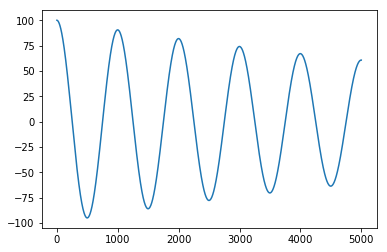

In [4]:
lahead = 1

expected_output=np.zeros((len(cos),1))
for i in range(len(cos)-lahead):
    expected_output[i,0]=np.mean(cos[i+1:i+lahead+1])
    
plt.plot(cos[:,0,0])
plt.show()

In [5]:
tsteps = 1
batch_size = 25

model = Sequential()
model.add(LSTM(50, input_shape=(tsteps, 1), 
               batch_size=batch_size,
               return_sequences=True,
               stateful=True))
model.add(LSTM(50, return_sequences=False,
               stateful=True))
model.add(Dense(1))
model.summary()

model.compile(loss='mse', optimizer='rmsprop') # 回帰なのでlossはmseを選択

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (25, 1, 50)               10400     
_________________________________________________________________
lstm_2 (LSTM)                (25, 50)                  20200     
_________________________________________________________________
dense_1 (Dense)              (25, 1)                   51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [6]:
epochs = 25

for i in range(epochs):
    print('Epoch', i, '/', epochs)
    model.fit(cos,expected_output,
              batch_size=batch_size,
              epochs=1,
              verbose=1,
              shuffle=False)
    model.reset_states()

Epoch 0 / 25
Epoch 1/1
5000/5000 [==============================] - 2s - loss: 2814.0958     
Epoch 1 / 25
Epoch 1/1
5000/5000 [==============================] - 1s - loss: 2211.4934     
Epoch 2 / 25
Epoch 1/1
5000/5000 [==============================] - 1s - loss: 1722.7700     
Epoch 3 / 25
Epoch 1/1
5000/5000 [==============================] - 1s - loss: 1353.9920     
Epoch 4 / 25
Epoch 1/1
5000/5000 [==============================] - 1s - loss: 956.9345     
Epoch 5 / 25
Epoch 1/1
5000/5000 [==============================] - 1s - loss: 640.8804     
Epoch 6 / 25
Epoch 1/1
5000/5000 [==============================] - 1s - loss: 446.4497     
Epoch 7 / 25
Epoch 1/1
5000/5000 [==============================] - 1s - loss: 322.0931     
Epoch 8 / 25
Epoch 1/1
5000/5000 [==============================] - 1s - loss: 267.0605     
Epoch 9 / 25
Epoch 1/1
5000/5000 [==============================] - 1s - loss: 201.1595     
Epoch 10 / 25
Epoch 1/1
5000/5000 [==============================]

/Users/sugakubunka/.pyenv/versions/anaconda3-4.4.0/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


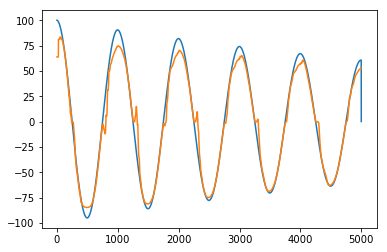

In [7]:
predicted_output = model.predict(cos,batch_size=batch_size)

plt.plot(expected_output)
plt.plot(predicted_output)
plt.legend()
plt.show()

### LSTMによる足し算の学習
https://github.com/keras-team/keras/blob/master/examples/addition_rnn.py

In [6]:
from keras.models import Sequential
from keras import layers
import numpy as np
from six.moves import range

In [7]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))

    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x

    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return ''.join(self.indices_char[x] for x in x)

In [8]:
class colors:
    ok = '\033[92m'
    fail = '\033[91m'
    close = '\033[0m'

In [9]:
TRAINING_SIZE = 50000
DIGITS = 3
INVERT = True
MAXLEN = DIGITS + 1 + DIGITS

chars = '0123456789+ '
ctable = CharacterTable(chars)

In [10]:
questions = []
expected = []
seen = set()
print('Generating data...')
while len(questions) < TRAINING_SIZE:
    f = lambda: int(''.join(np.random.choice(list('0123456789'))
                            for i in range(np.random.randint(1, DIGITS + 1))))
    a, b = f(), f()
    # Skip any addition questions we've already seen
    # Also skip any such that x+Y == Y+x (hence the sorting).
    key = tuple(sorted((a, b)))
    if key in seen:
        continue
    seen.add(key)
    # Pad the data with spaces such that it is always MAXLEN.
    q = '{}+{}'.format(a, b)
    query = q + ' ' * (MAXLEN - len(q))
    ans = str(a + b)
    # Answers can be of maximum size DIGITS + 1.
    ans += ' ' * (DIGITS + 1 - len(ans))
    if INVERT:
        # Reverse the query, e.g., '12+345  ' becomes '  543+21'. (Note the
        # space used for padding.)
        query = query[::-1]
    questions.append(query)
    expected.append(ans)
print('Total addition questions:', len(questions))

Generating data...
Total addition questions: 50000


In [11]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.bool)
y = np.zeros((len(questions), DIGITS + 1, len(chars)), dtype=np.bool)
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)

Vectorization...


In [12]:
# Shuffle (x, y) in unison as the later parts of x will almost all be larger
# digits.
indices = np.arange(len(y))
np.random.shuffle(indices)
x = x[indices]
y = y[indices]

In [13]:
# Explicitly set apart 10% for validation data that we never train over.
split_at = len(x) - len(x) // 10
(x_train, x_val) = x[:split_at], x[split_at:]
(y_train, y_val) = y[:split_at], y[split_at:]

print('Training Data:')
print(x_train.shape)
print(y_train.shape)

print('Validation Data:')
print(x_val.shape)
print(y_val.shape)

Training Data:
(45000, 7, 12)
(45000, 4, 12)
Validation Data:
(5000, 7, 12)
(5000, 4, 12)


In [17]:
# Try replacing GRU, or SimpleRNN.
RNN = layers.LSTM
HIDDEN_SIZE = 128
BATCH_SIZE = 128
LAYERS = 1

print('Build model...')
model = Sequential()
# "Encode" the input sequence using an RNN, producing an output of HIDDEN_SIZE.
# Note: In a situation where your input sequences have a variable length,
# use input_shape=(None, num_feature).
model.add(RNN(HIDDEN_SIZE, input_shape=(MAXLEN, len(chars))))
# As the decoder RNN's input, repeatedly provide with the last hidden state of
# RNN for each time step. Repeat 'DIGITS + 1' times as that's the maximum
# length of output, e.g., when DIGITS=3, max output is 999+999=1998.
model.add(layers.RepeatVector(DIGITS + 1))
# The decoder RNN could be multiple layers stacked or a single layer.
for _ in range(LAYERS):
    # By setting return_sequences to True, return not only the last output but
    # all the outputs so far in the form of (num_samples, timesteps,
    # output_dim). This is necessary as TimeDistributed in the below expects
    # the first dimension to be the timesteps.
    model.add(RNN(HIDDEN_SIZE, return_sequences=True))
    
# Apply a dense layer to the every temporal slice of an input. For each of step
# of the output sequence, decide which character should be chosen.
model.add(layers.TimeDistributed(layers.Dense(len(chars))))
model.add(layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               72192     
_________________________________________________________________
repeat_vector_2 (RepeatVecto (None, 4, 128)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 4, 128)            131584    
_________________________________________________________________
time_distributed_2 (TimeDist (None, 4, 12)             1548      
_________________________________________________________________
activation_2 (Activation)    (None, 4, 12)             0         
Total params: 205,324
Trainable params: 205,324
Non-trainable params: 0
_________________________________________________________________


In [18]:
for iteration in range(1, 200): # ほんとは200回iteration
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(x_train, y_train,
              batch_size=BATCH_SIZE,
              epochs=1,
              validation_data=(x_val, y_val))
    # Select 10 samples from the validation set at random so we can visualize
    # errors.
    for i in range(100):
        ind = np.random.randint(0, len(x_val))
        rowx, rowy = x_val[np.array([ind])], y_val[np.array([ind])]
        preds = model.predict_classes(rowx, verbose=0)
        q = ctable.decode(rowx[0])
        correct = ctable.decode(rowy[0])
        guess = ctable.decode(preds[0], calc_argmax=False)
        print('Q', q[::-1] if INVERT else q)
        print('T', correct)
        if correct == guess:
            print(colors.ok + '☑' + colors.close, end=" ")
        else:
            print(colors.fail + '☒' + colors.close, end=" ")
        print(guess)
        print('---')   


--------------------------------------------------
Iteration 1
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45000 [==============================] - 16s 366us/step - loss: 1.8891 - acc: 0.3215 - val_loss: 1.7832 - val_acc: 0.3326
Q 71+385 
T 456 
☒ 122 
---
Q 4+314  
T 318 
☒ 22  
---
Q 69+653 
T 722 
☒ 122 
---
Q 68+771 
T 839 
☒ 122 
---
Q 852+9  
T 861 
☒ 122 
---
Q 109+7  
T 116 
☒ 22  
---
Q 71+728 
T 799 
☒ 122 
---
Q 37+661 
T 698 
☒ 622 
---
Q 716+822
T 1538
☒ 122 
---
Q 826+521
T 1347
☒ 122 
---
Q 229+767
T 996 
☒ 122 
---
Q 201+880
T 1081
☒ 122 
---
Q 459+43 
T 502 
☒ 122 
---
Q 499+411
T 910 
☒ 122 
---
Q 875+2  
T 877 
☒ 122 
---
Q 175+893
T 1068
☒ 122 
---
Q 70+130 
T 200 
☒ 122 
---
Q 71+385 
T 456 
☒ 122 
---
Q 572+491
T 1063
☒ 122 
---
Q 378+76 
T 454 
☒ 122 
---
Q 154+7  
T 161 
☒ 22  
---
Q 32+79  
T 111 
☒ 22  
---
Q 9+209  
T 218 
☒ 122 
---
Q 984+939
T 1923
☒ 1122
---
Q 277+580
T 857 
☒ 122 
---
Q 663+2  
T 665 
☒ 22  
---
Q 81+674 
T 755 
☒ 12

T 100 
☒ 229 
---
Q 52+9   
T 61  
☒ 10  
---
Q 85+975 
T 1060
☒ 1055
---
Q 43+813 
T 856 
☒ 881 
---
Q 97+863 
T 960 
☒ 1054
---
Q 35+605 
T 640 
☒ 593 
---
Q 30+766 
T 796 
☒ 704 
---
Q 65+404 
T 469 
☒ 542 
---
Q 71+29  
T 100 
☒ 11  
---
Q 576+4  
T 580 
☒ 669 
---
Q 547+780
T 1327
☒ 1544
---
Q 62+26  
T 88  
☒ 12  
---
Q 953+58 
T 1011
☒ 100 
---
Q 808+468
T 1276
☒ 1244
---
Q 8+937  
T 945 
☒ 994 
---
Q 47+256 
T 303 
☒ 469 
---
Q 73+986 
T 1059
☒ 1084
---
Q 78+182 
T 260 
☒ 289 
---
Q 52+34  
T 86  
☒ 14  
---
Q 204+315
T 519 
☒ 546 
---
Q 379+32 
T 411 
☒ 441 
---
Q 994+9  
T 1003
☒ 900 
---
Q 417+432
T 849 
☒ 706 
---
Q 676+732
T 1408
☒ 1244
---
Q 809+144
T 953 
☒ 100 
---
Q 830+12 
T 842 
☒ 984 
---
Q 98+489 
T 587 
☒ 902 
---
Q 96+550 
T 646 
☒ 603 
---
Q 3+684  
T 687 
☒ 744 
---
Q 809+144
T 953 
☒ 100 
---
Q 192+113
T 305 
☒ 244 
---
Q 584+5  
T 589 
☒ 559 
---
Q 879+86 
T 965 
☒ 100 
---
Q 5+282  
T 287 
☒ 282 
---
Q 68+956 
T 1024
☒ 1054
---
Q 30+778 
T 808 
☒ 894 
---

-

45000/45000 [==============================] - 14s 315us/step - loss: 1.1264 - acc: 0.5864 - val_loss: 1.0599 - val_acc: 0.6116
Q 312+317
T 629 
☒ 555 
---
Q 79+524 
T 603 
☒ 507 
---
Q 546+484
T 1030
☒ 1039
---
Q 631+83 
T 714 
☒ 722 
---
Q 6+60   
T 66  
☑ 66  
---
Q 555+83 
T 638 
☒ 632 
---
Q 830+325
T 1155
☒ 1175
---
Q 650+653
T 1303
☒ 1389
---
Q 465+7  
T 472 
☒ 470 
---
Q 936+696
T 1632
☒ 1733
---
Q 50+380 
T 430 
☒ 407 
---
Q 51+572 
T 623 
☒ 613 
---
Q 609+176
T 785 
☒ 809 
---
Q 152+283
T 435 
☒ 419 
---
Q 65+52  
T 117 
☒ 127 
---
Q 133+9  
T 142 
☒ 148 
---
Q 751+402
T 1153
☒ 1175
---
Q 374+178
T 552 
☒ 539 
---
Q 151+44 
T 195 
☒ 187 
---
Q 55+166 
T 221 
☒ 215 
---
Q 61+909 
T 970 
☑ 970 
---
Q 77+313 
T 390 
☒ 397 
---
Q 654+554
T 1208
☒ 1199
---
Q 890+382
T 1272
☒ 1255
---
Q 141+852
T 993 
☒ 905 
---
Q 86+579 
T 665 
☒ 655 
---
Q 920+4  
T 924 
☒ 923 
---
Q 740+325
T 1065
☒ 1076
---
Q 399+16 
T 415 
☒ 400 
---
Q 90+0   
T 90  
☑ 90  
---
Q 69+391 
T 460 
☒ 445 
---
Q 23

---
Q 723+516
T 1239
☒ 1140
---
Q 51+349 
T 400 
☒ 403 
---
Q 422+73 
T 495 
☒ 598 
---
Q 59+245 
T 304 
☒ 309 
---
Q 697+737
T 1434
☒ 1444
---
Q 285+54 
T 339 
☒ 342 
---
Q 980+466
T 1446
☒ 1343
---
Q 29+517 
T 546 
☒ 549 
---
Q 72+115 
T 187 
☒ 174 
---
Q 7+616  
T 623 
☒ 621 
---
Q 3+244  
T 247 
☒ 242 
---
Q 257+780
T 1037
☒ 1036
---
Q 344+745
T 1089
☒ 1086
---
Q 76+1   
T 77  
☑ 77  
---
Q 181+629
T 810 
☒ 709 
---
Q 271+92 
T 363 
☒ 352 
---
Q 27+668 
T 695 
☒ 696 
---
Q 7+692  
T 699 
☒ 691 
---
Q 826+78 
T 904 
☒ 909 
---
Q 859+832
T 1691
☒ 1694
---
Q 15+851 
T 866 
☒ 864 
---
Q 8+174  
T 182 
☑ 182 
---
Q 44+745 
T 789 
☒ 794 
---
Q 37+149 
T 186 
☒ 179 
---
Q 92+973 
T 1065
☒ 1051
---
Q 837+184
T 1021
☒ 1016
---
Q 63+932 
T 995 
☒ 999 
---
Q 528+601
T 1129
☒ 1130
---
Q 89+809 
T 898 
☒ 893 
---
Q 749+63 
T 812 
☒ 814 
---
Q 42+950 
T 992 
☒ 989 
---
Q 16+990 
T 1006
☒ 100 
---
Q 3+244  
T 247 
☒ 242 
---

--------------------------------------------------
Iteration 9
Train on

45000/45000 [==============================] - 14s 303us/step - loss: 0.6373 - acc: 0.7777 - val_loss: 0.5623 - val_acc: 0.7974
Q 214+41 
T 255 
☑ 255 
---
Q 28+34  
T 62  
☒ 61  
---
Q 780+674
T 1454
☑ 1454
---
Q 3+326  
T 329 
☒ 328 
---
Q 49+809 
T 858 
☒ 855 
---
Q 199+598
T 797 
☒ 687 
---
Q 407+9  
T 416 
☑ 416 
---
Q 83+42  
T 125 
☑ 125 
---
Q 91+10  
T 101 
☑ 101 
---
Q 892+68 
T 960 
☒ 958 
---
Q 0+752  
T 752 
☑ 752 
---
Q 4+28   
T 32  
☒ 31  
---
Q 23+251 
T 274 
☑ 274 
---
Q 570+342
T 912 
☑ 912 
---
Q 726+2  
T 728 
☑ 728 
---
Q 611+45 
T 656 
☑ 656 
---
Q 983+279
T 1262
☒ 1161
---
Q 74+647 
T 721 
☒ 722 
---
Q 1+875  
T 876 
☒ 875 
---
Q 80+266 
T 346 
☒ 345 
---
Q 557+950
T 1507
☒ 1407
---
Q 934+56 
T 990 
☒ 980 
---
Q 77+174 
T 251 
☒ 252 
---
Q 0+237  
T 237 
☒ 227 
---
Q 47+160 
T 207 
☒ 195 
---
Q 676+732
T 1408
☒ 1409
---
Q 29+725 
T 754 
☒ 753 
---
Q 40+719 
T 759 
☑ 759 
---
Q 691+6  
T 697 
☑ 697 
---
Q 494+83 
T 577 
☒ 570 
---
Q 97+155 
T 252 
☑ 252 
---
Q 87

Q 3+36   
T 39  
☒ 48  
---
Q 507+235
T 742 
☑ 742 
---
Q 23+150 
T 173 
☑ 173 
---
Q 246+76 
T 322 
☑ 322 
---
Q 54+814 
T 868 
☑ 868 
---
Q 417+27 
T 444 
☑ 444 
---
Q 180+309
T 489 
☒ 599 
---
Q 316+17 
T 333 
☑ 333 
---
Q 524+277
T 801 
☑ 801 
---
Q 961+3  
T 964 
☑ 964 
---
Q 52+209 
T 261 
☑ 261 
---
Q 544+65 
T 609 
☒ 619 
---
Q 472+833
T 1305
☑ 1305
---
Q 917+30 
T 947 
☑ 947 
---
Q 8+659  
T 667 
☑ 667 
---
Q 96+95  
T 191 
☒ 181 
---
Q 318+4  
T 322 
☒ 332 
---
Q 84+394 
T 478 
☑ 478 
---
Q 90+85  
T 175 
☑ 175 
---
Q 767+33 
T 800 
☑ 800 
---
Q 8+295  
T 303 
☑ 303 
---
Q 520+13 
T 533 
☑ 533 
---
Q 95+657 
T 752 
☑ 752 
---
Q 905+75 
T 980 
☑ 980 
---
Q 495+69 
T 564 
☑ 564 
---
Q 87+789 
T 876 
☑ 876 
---
Q 853+53 
T 906 
☑ 906 
---
Q 63+340 
T 403 
☒ 413 
---
Q 130+86 
T 216 
☑ 216 
---
Q 773+181
T 954 
☒ 844 
---
Q 38+109 
T 147 
☑ 147 
---

--------------------------------------------------
Iteration 14
Train on 45000 samples, validate on 5000 samples
Epoch 1/1
45000/45

33792/45000 [=====================>........] - ETA: 3s - loss: 0.1116 - acc: 0.9827

KeyboardInterrupt: 

LSTMによる文書生成

In [18]:
#https://github.com/fchollet/keras/blob/master/examples/lstm_text_generation.py
'''Example script to generate text from Nietzsche's writings.
At least 20 epochs are required before the generated text
starts sounding coherent.
It is recommended to run this script on GPU, as recurrent
networks are quite computationally intensive.
If you try this script on new data, make sure your corpus
has at least ~100k characters. ~1M is better.
'''

from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from keras.optimizers import RMSprop
from keras.utils.data_utils import get_file
import numpy as np
import random
import sys

path = get_file('nietzsche.txt', origin='https://s3.amazonaws.com/text-datasets/nietzsche.txt')
text = open(path).read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 40
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('nb sequences:', len(sentences))

print('Vectorization...')
X = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        X[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1


# build the model: a single LSTM
print('Build model...')
model = Sequential()
model.add(LSTM(128, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars)))
model.add(Activation('softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)


def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

# train the model, output generated text after each iteration
for iteration in range(1, 2): # ほんとは60 iterations
    print()
    print('-' * 50)
    print('Iteration', iteration)
    model.fit(X, y,
              batch_size=128,
              epochs=1)

    start_index = random.randint(0, len(text) - maxlen - 1)

    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print()
        print('----- diversity:', diversity)

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('----- Generating with seed: "' + sentence + '"')
        sys.stdout.write(generated)

        for i in range(400):
            x = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x[0, t, char_indices[char]] = 1.

            preds = model.predict(x, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            generated += next_char
            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

475136/600901 [======================>.......] - ETA: 0scorpus length: 600893
total chars: 57
nb sequences: 200285
Vectorization...
Build model...

--------------------------------------------------
Iteration 1
Epoch 1/1
200285/200285 [==============================] - 333s - loss: 2.0002   

----- diversity: 0.2
----- Generating with seed: "dered now apart from ethic; it _will_ [h"
dered now apart from ethic; it _will_ [ho the can be the can in the sense of the sense of the some and so indelfect of in the sention of the sense of the sen all the sense the sen in the strenge of the sen in the still the strang the so far and in the sacrion of the propention of the sorre of the sen in the speated to the still the strated of all the sen all the sen in the conterned of the such of the conterned to the some and in the sa

----- diversity: 0.5
----- Generating with seed: "dered now apart from ethic; it _will_ [h"
dered now apart from ethic; it _will_ [he can and conserned of sense of indestin

## 課題

IMDBデータの分析をしよう。
講座の前半で扱ったロジスティック回帰、SVM、ランダムフォレストなどのディープラーニング以外の手法、後半で扱ったディープラーニング系の手法をそれぞれ一つ以上実施すること。
またパラメータのチューニングやデータの前処理など、結果を改善するための取り組みも行うこと。

### 扱うデータについて

感情 (肯定/否定) のラベル付けをされた，25,000のIMDB映画レビューのデータセット．レビューは前処理済みで，各レビューは単語のインデックス（整数）のシーケンスとしてエンコードされています．便宜上，単語はデータセットにおいての出現頻度によってインデックスされています．そのため例えば，整数"3"はデータの中で3番目に頻度が多い単語にエンコードされます．これによって"上位20個の頻出語を除いた，上位10,000個の頻出語についてのみ考える"というようなフィルタリング作業を高速に行うことができます．

https://keras.io/ja/datasets/

In [19]:
from keras.datasets import imdb
(x_train,  y_train), (x_test, y_test) = imdb.load_data()

print(x_train.shape, y_train.shape)

17432576/17464789 [============================>.] - ETA: 0s(25000,) (25000,)


### 特徴量の抽出について

一つの手法として、各単語のの出現頻度を特徴量として分析するというものがある。
例えば以下のような方法でデータを変換できる。

In [20]:
texts=[[1,10,5,2,10,5,3,1], [1,1,2,6,1,7,4]]
counts=[]

import collections
for t in texts:
    counts.append(collections.Counter(t))

In [21]:
counts

[Counter({1: 2, 2: 1, 3: 1, 5: 2, 10: 2}),
 Counter({1: 3, 2: 1, 4: 1, 6: 1, 7: 1})]

In [22]:
#http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer()
v.fit_transform(counts).toarray()

array([[ 2.,  1.,  1.,  0.,  2.,  0.,  0.,  2.],
       [ 3.,  1.,  0.,  1.,  0.,  1.,  1.,  0.]])

### IMDBの分析例

Kerasのコードサンプル
https://github.com/fchollet/keras/tree/master/examples

この中でIMDBの分析コード例としてはCNNを用いたもの、LSTMを用いたものなどがある。

他の手法との比較。TF-IDF + logisticとか

In [23]:
#https://github.com/fchollet/keras/blob/master/examples/imdb_cnn.py
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.datasets import imdb

# set parameters:
max_features = 5000
maxlen = 400
batch_size = 32
embedding_dims = 50
filters = 250
kernel_size = 3
hidden_dims = 250
epochs = 2

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))
model.add(Dropout(0.2))

# we add a Convolution1D, which will learn filters
# word group filters of size filter_length:
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
# we use max pooling:
model.add(GlobalMaxPooling1D())

# We add a vanilla hidden layer:
model.add(Dense(hidden_dims))
model.add(Dropout(0.2))
model.add(Activation('relu'))

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 400)
x_test shape: (25000, 400)
Build model...
Train on 25000 samples, validate on 25000 samples
Epoch 1/2
25000/25000 [==============================] - 236s - loss: 0.4142 - acc: 0.7987 - val_loss: 0.2915 - val_acc: 0.8763
Epoch 2/2
25000/25000 [==============================] - 225s - loss: 0.2369 - acc: 0.9049 - val_loss: 0.2697 - val_acc: 0.8892


In [24]:
#https://github.com/fchollet/keras/blob/master/examples/imdb_cnn_lstm.py
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras.datasets import imdb

# Embedding
max_features = 20000
maxlen = 100
embedding_size = 128

# Convolution
kernel_size = 5
filters = 64
pool_size = 4

# LSTM
lstm_output_size = 70

# Training
batch_size = 30
epochs = 1

'''
Note:
batch_size is highly sensitive.
Only 2 epochs are needed as the dataset is very small.
'''

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')

model = Sequential()
model.add(Embedding(max_features, embedding_size, input_length=maxlen))
model.add(Dropout(0.25))
model.add(Conv1D(filters,
                 kernel_size,
                 padding='valid',
                 activation='relu',
                 strides=1))
model.add(MaxPooling1D(pool_size=pool_size))
model.add(LSTM(lstm_output_size))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 100)
x_test shape: (25000, 100)
Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 18s    
Test score: 0.344865115315
Test accuracy: 0.853439994216


In [25]:
#https://github.com/fchollet/keras/blob/master/examples/imdb_fasttext.py
import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import GlobalAveragePooling1D
from keras.datasets import imdb


def create_ngram_set(input_list, ngram_value=2):
    """
    Extract a set of n-grams from a list of integers.
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=2)
    {(4, 9), (4, 1), (1, 4), (9, 4)}
    >>> create_ngram_set([1, 4, 9, 4, 1, 4], ngram_value=3)
    [(1, 4, 9), (4, 9, 4), (9, 4, 1), (4, 1, 4)]
    """
    return set(zip(*[input_list[i:] for i in range(ngram_value)]))


def add_ngram(sequences, token_indice, ngram_range=2):
    """
    Augment the input list of list (sequences) by appending n-grams values.
    Example: adding bi-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017}
    >>> add_ngram(sequences, token_indice, ngram_range=2)
    [[1, 3, 4, 5, 1337, 2017], [1, 3, 7, 9, 2, 1337, 42]]
    Example: adding tri-gram
    >>> sequences = [[1, 3, 4, 5], [1, 3, 7, 9, 2]]
    >>> token_indice = {(1, 3): 1337, (9, 2): 42, (4, 5): 2017, (7, 9, 2): 2018}
    >>> add_ngram(sequences, token_indice, ngram_range=3)
    [[1, 3, 4, 5, 1337], [1, 3, 7, 9, 2, 1337, 2018]]
    """
    new_sequences = []
    for input_list in sequences:
        new_list = input_list[:]
        for i in range(len(new_list) - ngram_range + 1):
            for ngram_value in range(2, ngram_range + 1):
                ngram = tuple(new_list[i:i + ngram_value])
                if ngram in token_indice:
                    new_list.append(token_indice[ngram])
        new_sequences.append(new_list)

    return new_sequences

# Set parameters:
# ngram_range = 2 will add bi-grams features
ngram_range = 1
max_features = 20000
maxlen = 400
batch_size = 32
embedding_dims = 50
epochs = 1

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')
print('Average train sequence length: {}'.format(np.mean(list(map(len, x_train)), dtype=int)))
print('Average test sequence length: {}'.format(np.mean(list(map(len, x_test)), dtype=int)))

if ngram_range > 1:
    print('Adding {}-gram features'.format(ngram_range))
    # Create set of unique n-gram from the training set.
    ngram_set = set()
    for input_list in x_train:
        for i in range(2, ngram_range + 1):
            set_of_ngram = create_ngram_set(input_list, ngram_value=i)
            ngram_set.update(set_of_ngram)

    # Dictionary mapping n-gram token to a unique integer.
    # Integer values are greater than max_features in order
    # to avoid collision with existing features.
    start_index = max_features + 1
    token_indice = {v: k + start_index for k, v in enumerate(ngram_set)}
    indice_token = {token_indice[k]: k for k in token_indice}

    # max_features is the highest integer that could be found in the dataset.
    max_features = np.max(list(indice_token.keys())) + 1

    # Augmenting x_train and x_test with n-grams features
    x_train = add_ngram(x_train, token_indice, ngram_range)
    x_test = add_ngram(x_test, token_indice, ngram_range)
    print('Average train sequence length: {}'.format(np.mean(list(map(len, x_train)), dtype=int)))
    print('Average test sequence length: {}'.format(np.mean(list(map(len, x_test)), dtype=int)))

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()

# we start off with an efficient embedding layer which maps
# our vocab indices into embedding_dims dimensions
model.add(Embedding(max_features,
                    embedding_dims,
                    input_length=maxlen))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model.add(GlobalAveragePooling1D())

# We project onto a single unit output layer, and squash it with a sigmoid:
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Loading data...
25000 train sequences
25000 test sequences
Average train sequence length: 238
Average test sequence length: 230
Pad sequences (samples x time)
x_train shape: (25000, 400)
x_test shape: (25000, 400)
Build model...
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
25000/25000 [==============================] - 10s - loss: 0.6103 - acc: 0.7399 - val_loss: 0.5036 - val_acc: 0.8104


In [26]:
# https://github.com/fchollet/keras/blob/master/examples/imdb_lstm.py
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb

max_features = 20000
maxlen = 80  # cut texts after this number of words (among top max_features most common words)
batch_size = 32
epochs = 1

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))
score, acc = model.evaluate(x_test, y_test,
                            batch_size=batch_size)
print('Test score:', score)
print('Test accuracy:', acc)

Loading data...
25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 80)
x_test shape: (25000, 80)
Build model...
Train...
Train on 25000 samples, validate on 25000 samples
Epoch 1/1
24992/25000 [============================>.] - ETA: 0sTest score: 0.387024600124
Test accuracy: 0.83308
